In [8]:
!pip install scipy



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
from scipy.io import loadmat
data = loadmat('Indian_pines.mat')
data


{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri May 20 18:20:38 2011',
 '__version__': '1.0',
 '__globals__': [],
 'indian_pines': array([[[3172, 4142, 4506, ..., 1020, 1020, 1005],
         [2580, 4266, 4502, ..., 1029, 1020, 1000],
         [3687, 4266, 4421, ..., 1030, 1016, 1009],
         ...,
         [2570, 3890, 4320, ..., 1021, 1015, 1025],
         [3170, 4130, 4320, ..., 1024, 1020, 1011],
         [3172, 3890, 4316, ..., 1034, 1016, 1015]],
 
        [[2576, 4388, 4334, ..., 1030, 1006, 1015],
         [2747, 4264, 4592, ..., 1039, 1015, 1020],
         [2750, 4268, 4423, ..., 1026, 1015, 1020],
         ...,
         [3859, 4512, 4605, ..., 1035, 1015,  996],
         [3686, 4264, 4690, ..., 1012, 1020, 1014],
         [2744, 4268, 4597, ..., 1019, 1016, 1010]],
 
        [[2744, 4146, 4416, ..., 1029, 1025, 1010],
         [2576, 4389, 4416, ..., 1021, 1011, 1000],
         [2744, 4273, 4420, ..., 1033, 1010, 1014],
         ...,
         [2570, 4

In [12]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

#  1. DATA LOADING AND EXTRACTION (Mean Band)

try:
    
    data = loadmat('Indian_pines.mat')
    hyperspectral_cube = data['indian_pines']
    hyperspectral_cube = hyperspectral_cube.astype(np.float64)
    
    # Calculating the average of all bands (Mean Spectral Image)
    single_band_image = np.mean(hyperspectral_cube, axis=2)
    
    print("Data Loaded Successfully.")
    print(f"Original Cube Shape: {hyperspectral_cube.shape}")
    print(f"Mean Band Image Shape: {single_band_image.shape}")

except FileNotFoundError:
    print("ERROR: 'Indian_pines.mat' not found. Ensure it is in the same folder as this notebook.")
    single_band_image = np.random.randint(0, 4096, (145, 145), dtype=np.uint16).astype(np.float64)
except KeyError:
    print("ERROR: Could not find the key 'indian_pines'. Please check your 'data.keys()' output.")





Data Loaded Successfully.
Original Cube Shape: (145, 145, 220)
Mean Band Image Shape: (145, 145)


Data Loaded Successfully.
Cube Shape: (145, 145, 220)
Processing Band 125 with Shape: (145, 145)


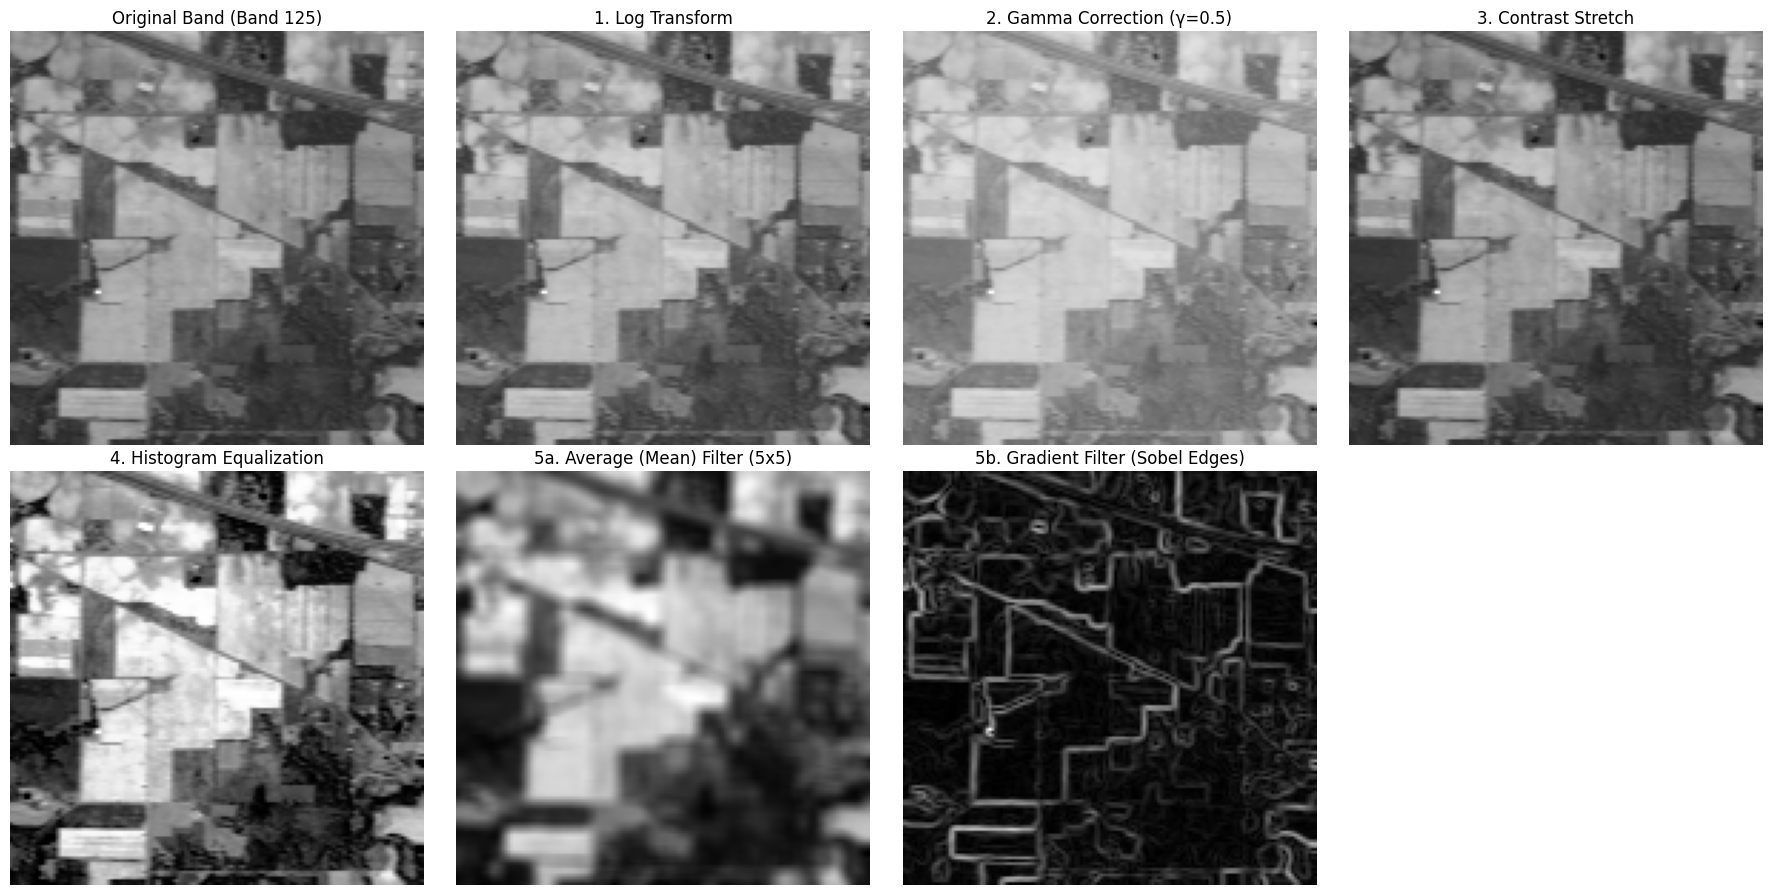

In [13]:
# 1. DATA LOADING AND EXTRACTION 

try:
    data = loadmat('Indian_pines.mat')
    
    # Extract the main image cube (common key for this dataset)
    hyperspectral_cube = data['indian_pines']
    
    hyperspectral_cube = hyperspectral_cube.astype(np.float64)
    
    # Selecting a single band (e.g., Band 125) for 2D processing demonstration
    band_index = 125 
    single_band_image = hyperspectral_cube[:, :, band_index]
    
    print(f"Data Loaded Successfully.")
    print(f"Cube Shape: {hyperspectral_cube.shape}")
    print(f"Processing Band {band_index} with Shape: {single_band_image.shape}")

except FileNotFoundError:
    print("ERROR: 'Indian_pines.mat' not found. Ensure it is in the same folder as this notebook.")

    single_band_image = np.random.randint(0, 4096, (145, 145), dtype=np.uint16).astype(np.float64)


# 2. FROM-SCRATCH IMPLEMENTATION CLASS

class HyperspectralProcessor:
    """
    Implements fundamental image processing algorithms from scratch 
    on a single 2D hyperspectral band.
    """

    def __init__(self, band_image):
        """
        Initializes the processor. The input band is normalized to [0, 1] 
        to ensure mathematical stability for Log/Gamma transforms.
        """
        if band_image.ndim != 2:
            raise ValueError("Input must be a 2D image band.")
        
        self.rows, self.cols = band_image.shape
        
        # Normalize the image data to [0, 1]
        self.min_val = band_image.min()
        self.max_val = band_image.max()
        
        # Handle case where the band is entirely uniform (max == min)
        if self.max_val - self.min_val == 0:
            self.image = np.zeros_like(band_image, dtype=np.float64)
        else:
            self.image = (band_image - self.min_val) / (self.max_val - self.min_val)

    # -----------------------------------------------------------
    # 1. Log Transform: s = c * log(1 + r)
    # -----------------------------------------------------------
    def log_transform(self, c=1.0):
        """
        Applies the Log Transform to compress dynamic range.
        """
        log_img = c * np.log(1 + self.image)
        l_min, l_max = log_img.min(), log_img.max()
        if l_max - l_min == 0:
            return np.zeros_like(log_img)
        return (log_img - l_min) / (l_max - l_min)

    # -----------------------------------------------------------
    # 2. Gamma Correction (Power Law): s = c * r^gamma
    # -----------------------------------------------------------
    def gamma_correction(self, gamma=1.0, c=1.0):
        """
        Applies Gamma Correction for tone adjustment (γ < 1 brightens, γ > 1 darkens).
        """
        gamma_img = c * (self.image ** gamma)
        return np.clip(gamma_img, 0, 1)

    # -----------------------------------------------------------
    # 3. Contrast Stretching
    # -----------------------------------------------------------
    def contrast_stretching(self, r_min=None, r_max=None, s_min=0.0, s_max=1.0):
        """
        Applies linear contrast stretching.
        """
        r = self.image
        r_min = r.min() if r_min is None else r_min
        r_max = r.max() if r_max is None else r_max

        denominator = r_max - r_min
        if denominator == 0:
            return np.ones_like(r) * s_min

        # Core linear transformation
        stretched_image = ((s_max - s_min) / denominator) * (r - r_min) + s_min
        
        return np.clip(stretched_image, s_min, s_max)

    # -----------------------------------------------------------
    # 4. Histogram Equalization
    # -----------------------------------------------------------
    def histogram_equalization(self, num_levels=256):
        """
        Performs Histogram Equalization using CDF transformation.
        """
        quantized_image = np.round(self.image * (num_levels - 1)).astype(np.int32)
        
        hist, _ = np.histogram(quantized_image.flatten(), bins=num_levels, range=[0, num_levels-1])
        
        cdf = np.cumsum(hist)
        
        # Normalize the CDF to the transformation range [0, 1]
        N = self.rows * self.cols
        cdf_min = cdf[cdf > 0].min()
        cdf_normalized = (cdf - cdf_min) / (N - cdf_min)
        
        # Apply the transformation lookup table: s = (L - 1) * C(r)
        equalized_values = np.round(cdf_normalized * (num_levels - 1))
        equalized_image_q = equalized_values[quantized_image].astype(np.float64)
        return equalized_image_q / (num_levels - 1)

    # -----------------------------------------------------------
    # 5. Convolution Filters - Helper
    # -----------------------------------------------------------
    def _convolve(self, kernel):
        """Helper function to perform 2D convolution from scratch."""
        k_rows, k_cols = kernel.shape
        pad_rows = k_rows // 2
        pad_cols = k_cols // 2
        
        
        padded_image = np.pad(self.image, 
                              ((pad_rows, pad_rows), (pad_cols, pad_cols)), 
                              mode='edge')
        
        output_image = np.zeros_like(self.image, dtype=np.float64)
        
        # Iterating over every output pixel
        for i in range(self.rows):
            for j in range(self.cols):
                # Extract the Region of Interest (ROI) matching the kernel size
                roi = padded_image[i:i + k_rows, j:j + k_cols]
                
                # Element-wise multiplication (dot product) and summation
                output_image[i, j] = np.sum(roi * kernel)
                
        return output_image

    # A. Average (Mean) Filter
    def average_filter(self, kernel_size=3):
        """
        Applies a Mean (Average) Filter.
        """
        kernel = np.ones((kernel_size, kernel_size), dtype=np.float64) 
        kernel /= (kernel_size * kernel_size) # Normalize the kernel
        
        return self._convolve(kernel)

    # B. Gradient Filters (Edge Detection - Sobel)
    def gradient_filters(self):
        """
        Applies the Sobel operator to find image gradients (edges).
        Returns the gradient magnitude image.
        """
        # Sobel Kernels (3x3)
        G_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
        G_y_kernel = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]], dtype=np.float64)

        G_x = self._convolve(G_x_kernel)
        G_y = self._convolve(G_y_kernel)
        
        # Compute Gradient Magnitude: G = sqrt(G_x^2 + G_y^2)
        magnitude = np.sqrt(G_x**2 + G_y**2)
        
        # Re-normalize the magnitude image to [0, 1]
        mag_min, mag_max = magnitude.min(), magnitude.max()
        if mag_max - mag_min == 0:
            return np.zeros_like(magnitude)
            
        return (magnitude - mag_min) / (mag_max - mag_min)


# 3. EXECUTION AND VISUALIZATION

processor = HyperspectralProcessor(single_band_image)

# Apply all transformations
log_img = processor.log_transform(c=5.0)
gamma_img = processor.gamma_correction(gamma=0.5)
stretched_img = processor.contrast_stretching()
hist_eq_img = processor.histogram_equalization()
smoothed_img = processor.average_filter(kernel_size=5)
edge_img = processor.gradient_filters()

# Visualization
images = {
    "Original Band (Band 125)": processor.image,
    "1. Log Transform": log_img,
    "2. Gamma Correction (γ=0.5)": gamma_img,
    "3. Contrast Stretch": stretched_img,
    "4. Histogram Equalization": hist_eq_img,
    "5a. Average (Mean) Filter (5x5)": smoothed_img,
    "5b. Gradient Filter (Sobel Edges)": edge_img
}

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for i, (title, img) in enumerate(images.items()):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(title, fontsize=12)
    axes[i].axis('off')

if len(images) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()